In [1]:
# Install required libraries
!pip install yfinance timesfm

  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 755.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 4.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/8

In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=8b18a1c8149ee796fbdef15b8879c50a85cf0843c19976f5a10579d43b0a2478
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [4]:
import ta
# Download stock data from Yahoo Finance
ticker = 'AAPL'  # Example: Apple Inc.
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")

# Calculate moving averages
data['moving_avg_10'] = data['Close'].rolling(window=10).mean()
data['moving_avg_50'] = data['Close'].rolling(window=50).mean()
data['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['ema'] = ta.trend.EMAIndicator(data['Close'], window=10).ema_indicator()

# Drop rows with NaN values (caused by rolling window calculations)
data = data.dropna()

df = data[['Close', 'Volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']].reset_index()
df.columns = ['date', 'close', 'volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,close,volume,moving_avg_10,moving_avg_50,rsi,ema
date,,,,,,
2023-03-15,152.990005,77167900,151.038000,144.793400,58.315418,151.047700
2023-03-16,155.850006,76161100,152.032001,145.409000,62.786074,151.920847
2023-03-17,155.000000,98944600,152.429001,145.981800,60.702342,152.480693
2023-03-20,157.399994,73641400,152.786000,146.629400,64.304515,153.375111
2023-03-21,159.279999,73938300,153.553999,147.222600,66.866621,154.448727
...,...,...,...,...,...,...
2023-12-22,193.600006,37122800,195.747002,185.398801,54.609714,194.957922
2023-12-26,193.050003,28919300,195.734003,185.682801,53.026884,194.611027
2023-12-27,193.149994,48087700,195.578001,185.971400,53.291939,194.345385


In [5]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["volume"].append(df["volume"][start:context_end].tolist() + [df["volume"].iloc[context_end - 1]])
        examples["moving_avg_10"].append(df["moving_avg_10"][start:context_end].tolist() + [df["moving_avg_10"].iloc[context_end - 1]])
        examples["moving_avg_50"].append(df["moving_avg_50"][start:context_end].tolist() + [df["moving_avg_50"].iloc[context_end - 1]])
        examples["rsi"].append(df["rsi"][start:context_end].tolist() + [df["rsi"].iloc[context_end - 1]])
        examples["ema"].append(df["ema"][start:context_end].tolist() + [df["ema"].iloc[context_end - 1]])
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [6]:


# Define metrics
def mse(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.square(y_pred - y_true), axis=1, keepdims=True)

def mae(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs(y_pred - y_true), axis=1, keepdims=True)

In [7]:
import os
import time
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import timesfm
import ta
from itertools import combinations
import gc
import json

features = ["volume", "moving_avg_10", "moving_avg_50", "rsi", "ema"]
feature_combinations = []
for r in range(1, len(features) + 1):
    feature_combinations.extend(combinations(features, r))

context_lengths = [32, 64, 128]  # Adjust as needed
input_patch_lengths = [32, 64 , 128]  # Ensure these are smaller than the smallest context length
batch_sizes = range(1, 34, 5)  # Adjust batch sizes if memory issues persist

# Dictionary to store results
all_results = []
all_best_results = []

# Iterate over different context lengths and input patch lengths
for context_len in context_lengths:
    for input_patch_len in input_patch_lengths:
        if input_patch_len > context_len:
            continue  # Skip invalid combinations


        print(f"\nTesting Context Length: {context_len}, Input Patch Length: {input_patch_len}")

        # Initialize the model
        model = timesfm.TimesFm(
            context_len=context_len,
            horizon_len=1,
            input_patch_len=input_patch_len,
            output_patch_len=128,
            num_layers=20,
            model_dims=1280,
            backend=timesfm_backend,
        )

        # Load the model checkpoint with error handling
        try:
            model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")
        except Exception as e:
            print(f"Error loading checkpoint for context_len={context_len}, input_patch_len={input_patch_len}: {e}")
            continue  # Skip to the next iteration if loading fails

        results_summary_all = []

        for batch_size in batch_sizes:
            for reverse in [False, True]:
                xreg_mode = "xreg + timesfm" if reverse else "timesfm + xreg"
                if(not reverse and  input_patch_len == context_len):
                    continue

                print(f"Testing batch size: {batch_size}, mode: {xreg_mode}")

                results_summary = []

                for combo in feature_combinations:
                    input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=1)
                    metrics = defaultdict(list)
                    results = []

                    # Process in smaller sub-batches
                    for i, example in enumerate(input_data()):
                        raw_forecast, _ = model.forecast(
                            inputs=example["inputs"], freq=[0] * len(example["inputs"])
                        )
                        dynamic_numerical_covariates = {feature: example[feature] for feature in combo}

                        cov_forecast, ols_forecast = model.forecast_with_covariates(
                            inputs=example["inputs"],
                            dynamic_numerical_covariates=dynamic_numerical_covariates,
                            dynamic_categorical_covariates={},
                            static_numerical_covariates={},
                            static_categorical_covariates={},
                            freq=[0] * len(example["inputs"]),
                            normalize_xreg_target_per_input=True,
                            xreg_mode=xreg_mode,
                        )

                        for j in range(len(example["inputs"])):
                            result = {
                                'batch': i,
                                'input_index': j,
                                'train_start_date': str(example["dates"][j][0]),
                                'train_end_date': str(example["dates"][j][-2]),
                                'predict_date': str(example["dates"][j][-1]),
                                'raw_forecast': raw_forecast[j][0],
                                'y_actual': example["outputs"][j][0],
                                'y_predicted': cov_forecast[j][0],
                                'features': str(combo),
                                'batch_size': batch_size,
                                'reverse': reverse,
                                'xreg_mode': xreg_mode,
                                'context_len': context_len,
                                'input_patch_len': input_patch_len
                            }
                            results.append(result)

                    results_df = pd.DataFrame(results)

                    correct_predictions = 0
                    total_predictions = 0

                    for i in range(1, len(results_df)):
                        actual_today = results_df.iloc[i]['y_actual']
                        predicted_today = results_df.iloc[i]['y_predicted']
                        actual_yesterday_index = i - 1
                        actual_yesterday_date = results_df.iloc[actual_yesterday_index]['predict_date']

                        if pd.to_datetime(actual_yesterday_date) != pd.to_datetime(results_df.iloc[i]['predict_date']) - pd.DateOffset(days=1):
                            continue

                        actual_yesterday = results_df.iloc[actual_yesterday_index]['y_actual']
                        actual_movement = actual_today - actual_yesterday
                        predicted_movement = predicted_today - actual_yesterday

                        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
                            correct_predictions += 1

                        total_predictions += 1

                    accuracy = correct_predictions / total_predictions

                    results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')
                    initial_investment = 100
                    capital = initial_investment
                    shares = 0
                    profit = 0
                    capital_history = []

                    for i in range(len(results_df) - 1):
                        i = i + 1
                        if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
                            shares = capital / results_df.loc[i, 'y_actual']
                            capital = 0
                        elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:
                            capital = shares * results_df.loc[i, 'y_actual']
                            shares = 0
                        capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

                    final_capital = capital + shares * results_df.iloc[-1]['y_actual']
                    total_profit = final_capital - initial_investment

                    results_summary.append({
                        'features': combo,
                        'mse_model': mean_squared_error(results_df['y_actual'], results_df['y_predicted']),
                        'mse_naive': mean_squared_error(results_df['y_actual'], results_df['raw_forecast']),
                        'accuracy': accuracy,
                        'profit': total_profit,
                        'batch_size': batch_size,
                        'reverse': reverse,
                        'xreg_mode': xreg_mode,
                        'results_df' :results_df,
                        'context_len': context_len,
                        'input_patch_len': input_patch_len
                    })

                # Store the results
                results_summary_all.extend(results_summary)

                # Save the best results for each combination
                best_mse_model = min(results_summary, key=lambda x: x['mse_model'])
                best_accuracy = max(results_summary, key=lambda x: x['accuracy'])
                best_profit = max(results_summary, key=lambda x: x['profit'])

                best_results = {
                    'best_by_mse': best_mse_model,
                    'best_by_accuracy': best_accuracy,
                    'best_by_profit': best_profit,
                    'batch_size': batch_size,
                    'reverse': reverse,
                    'xreg_mode': xreg_mode,
                    'context_len': context_len,
                    'input_patch_len': input_patch_len,
                }
                all_best_results.append(best_results)

                # Save the results to a JSON file
                all_results.append(results_summary_all)

        # Clear memory
        del model
        gc.collect()  # Manually trigger garbage collection




Testing Context Length: 32, Input Patch Length: 32


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 5.58 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.40 seconds.
Jitting decoding.
Jitted decoding in 23.38 seconds.
Testing batch size: 1, mode: xreg + timesfm
Testing batch size: 6, mode: xreg + timesfm
Testing batch size: 11, mode: xreg + timesfm
Testing batch size: 16, mode: xreg + timesfm
Testing batch size: 21, mode: xreg + timesfm
Testing batch size: 26, mode: xreg + timesfm
Testing batch size: 31, mode: xreg + timesfm

Testing Context Length: 64, Input Patch Length: 32
Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 4.61 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 4.18 seconds.
Jitting decoding.
Jitted decoding in 19.82 seconds.
Testing batch size: 1, mode: timesfm + xreg
Testing batch size: 1, mode: xreg + timesfm
Testing batch size: 6, mode: timesfm + xreg
Testing batch size: 6, mode: xreg + timesfm
Testing batch size: 11, mode: timesfm + xreg
Testing batch size: 11, mode: xreg + timesfm
Testing batch size: 16, mode: timesfm + xreg
Testing batch size: 16, mode: xreg + timesfm
Testing batch size: 21, mode: timesfm + xreg
Testing batch size: 21, mode: xreg + timesfm
Testing batch size: 26, mode: timesfm + xreg
Testing batch size: 26, mode: xreg + timesfm
Testing batch size: 31, mode: timesfm + xreg
Testing batch size: 31, mode: xreg + timesfm

Testing Context Length: 64, Input Patch Length: 64
Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.01 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 4.19 seconds.
Jitting decoding.
Error loading checkpoint for context_len=64, input_patch_len=64: Initializer expected to generate shape (64, 1280) but got shape (128, 1280) instead for parameter "w" in "/input_ff_layer/hidden_layer/linear". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

Testing Context Length: 128, Input Patch Length: 32
Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.07 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.95 seconds.
Jitting decoding.
Jitted decoding in 18.22 seconds.
Testing batch size: 1, mode: timesfm + xreg
Testing batch size: 1, mode: xreg + timesfm
Testing batch size: 6, mode: timesfm + xreg
Testing batch size: 6, mode: xreg + timesfm
Testing batch size: 11, mode: timesfm + xreg
Testing batch size: 11, mode: xreg + timesfm
Testing batch size: 16, mode: timesfm + xreg
Testing batch size: 16, mode: xreg + timesfm
Testing batch size: 21, mode: timesfm + xreg
Testing batch size: 21, mode: xreg + timesfm
Testing batch size: 26, mode: timesfm + xreg
Testing batch size: 26, mode: xreg + timesfm
Testing batch size: 31, mode: timesfm + xreg
Testing batch size: 31, mode: xreg + timesfm

Testing Context Length: 128, Input Patch Length: 64
Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.07 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.62 seconds.
Jitting decoding.
Error loading checkpoint for context_len=128, input_patch_len=64: Initializer expected to generate shape (64, 1280) but got shape (128, 1280) instead for parameter "w" in "/input_ff_layer/hidden_layer/linear". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

Testing Context Length: 128, Input Patch Length: 128
Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.56 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.57 seconds.
Jitting decoding.
Error loading checkpoint for context_len=128, input_patch_len=128: Initializer expected to generate shape (64, 1280) but got shape (256, 1280) instead for parameter "w" in "/input_ff_layer/hidden_layer/linear". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)


TypeError: Object of type DataFrame is not JSON serializable

In [9]:
all_best_results

[{'best_by_mse': {'features': ('volume',
    'moving_avg_10',
    'moving_avg_50',
    'rsi'),
   'mse_model': 4.479383068228517,
   'mse_naive': 5.199387326334891,
   'accuracy': 0.5190839694656488,
   'profit': 14.860768113825642,
   'batch_size': 1,
   'reverse': True,
   'xreg_mode': 'xreg + timesfm',
   'results_df':      batch  input_index     train_start_date       train_end_date  \
   0        0            0  2023-03-15 00:00:00  2023-04-28 00:00:00   
   1        1            0  2023-03-16 00:00:00  2023-05-01 00:00:00   
   2        2            0  2023-03-17 00:00:00  2023-05-02 00:00:00   
   3        3            0  2023-03-20 00:00:00  2023-05-03 00:00:00   
   4        4            0  2023-03-21 00:00:00  2023-05-04 00:00:00   
   ..     ...          ...                  ...                  ...   
   163    163            0  2023-11-06 00:00:00  2023-12-20 00:00:00   
   164    164            0  2023-11-07 00:00:00  2023-12-21 00:00:00   
   165    165            0  202

In [29]:
import pandas as pd

# تبدیل all_results به یک DataFrame
flattened_results = [item for sublist in all_results for item in sublist]
results_df = pd.DataFrame(flattened_results)

# گروه‌بندی بر اساس context_len و input_patch_len
grouped = results_df.groupby(['context_len', 'input_patch_len'])

# تابع برای نمایش بهترین نتایج بر اساس معیارهای مختلف
def display_best_results(group, metric):
    print(f"\nBest {metric} per Batch Size:")
    print(group[['batch_size', 'features', 'mse_model', 'accuracy', 'profit', 'reverse', 'xreg_mode', 'context_len', 'input_patch_len']].to_string(index=False))

# پردازش و نمایش نتایج برای هر ترکیب
for (context_len, input_patch_len), group in grouped:
    print(f"\nProcessing results for Context Length: {context_len}, Input Patch Length: {input_patch_len}...")

    # پیدا کردن بهترین MSE، دقت و سود برای هر اندازه دسته
    best_mse_per_batch = group.loc[group.groupby('batch_size')['mse_model'].idxmin()]
    best_accuracy_per_batch = group.loc[group.groupby('batch_size')['accuracy'].idxmax()]
    best_profit_per_batch = group.loc[group.groupby('batch_size')['profit'].idxmax()]

    # نمایش نتایج
    display_best_results(best_mse_per_batch, 'MSE')
    display_best_results(best_accuracy_per_batch, 'Accuracy')
    display_best_results(best_profit_per_batch, 'Profit')



Processing results for Context Length: 32, Input Patch Length: 32...

Best MSE per Batch Size:
 batch_size                                    features  mse_model  accuracy    profit  reverse      xreg_mode  context_len  input_patch_len
          1 (volume, moving_avg_10, moving_avg_50, rsi)   4.479383  0.519084 14.860768     True xreg + timesfm           32               32
          6                (volume, moving_avg_50, rsi)   4.574531  0.549618 13.145297     True xreg + timesfm           32               32
         11 (volume, moving_avg_10, moving_avg_50, rsi)   4.587234  0.473282 11.116601     True xreg + timesfm           32               32
         16         (moving_avg_10, moving_avg_50, rsi)   4.650072  0.442748 10.570539     True xreg + timesfm           32               32
         21 (volume, moving_avg_10, moving_avg_50, rsi)   4.566522  0.465649 13.295594     True xreg + timesfm           32               32
         26                          (volume, rsi, ema)   


Analyzing for Input Patch Length: 32, Mode: timesfm + xreg, Reverse: False...


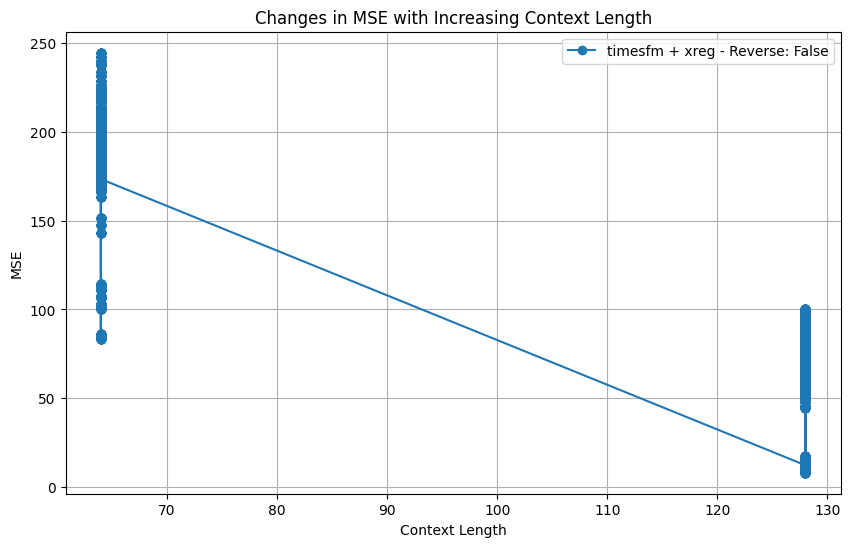

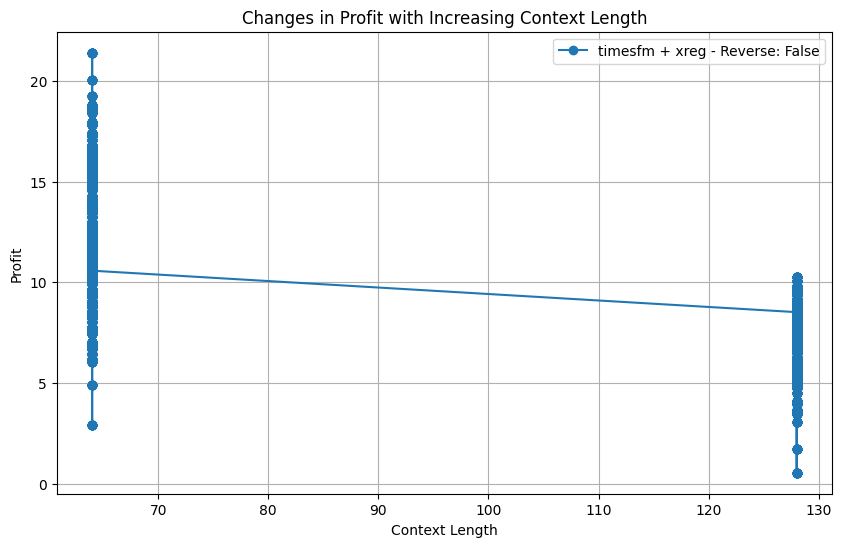

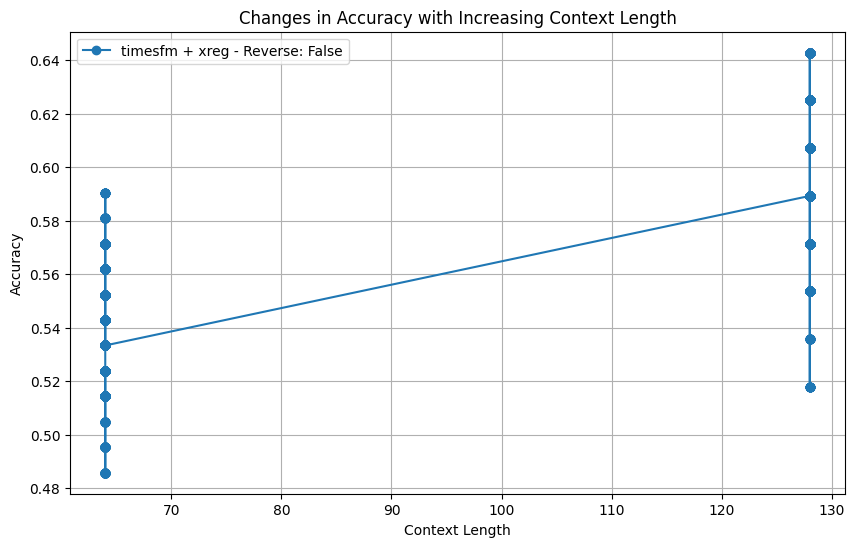


Analyzing for Input Patch Length: 32, Mode: xreg + timesfm, Reverse: True...


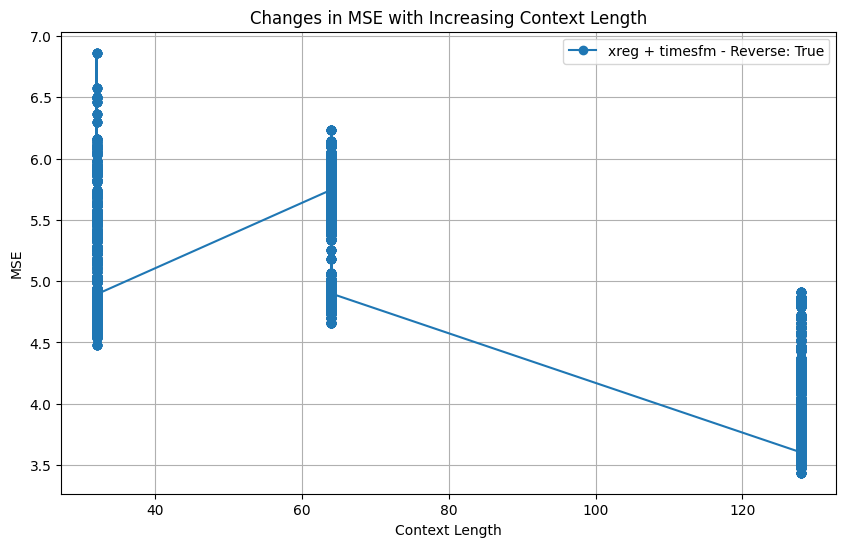

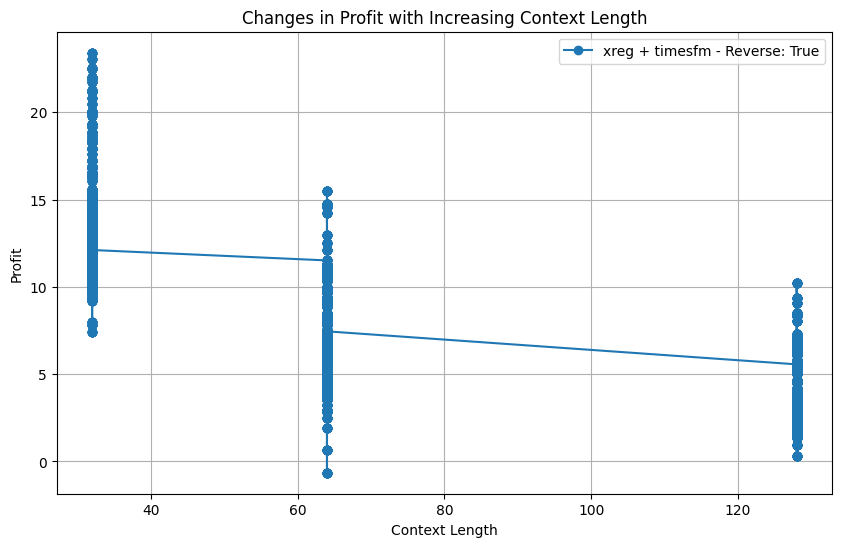

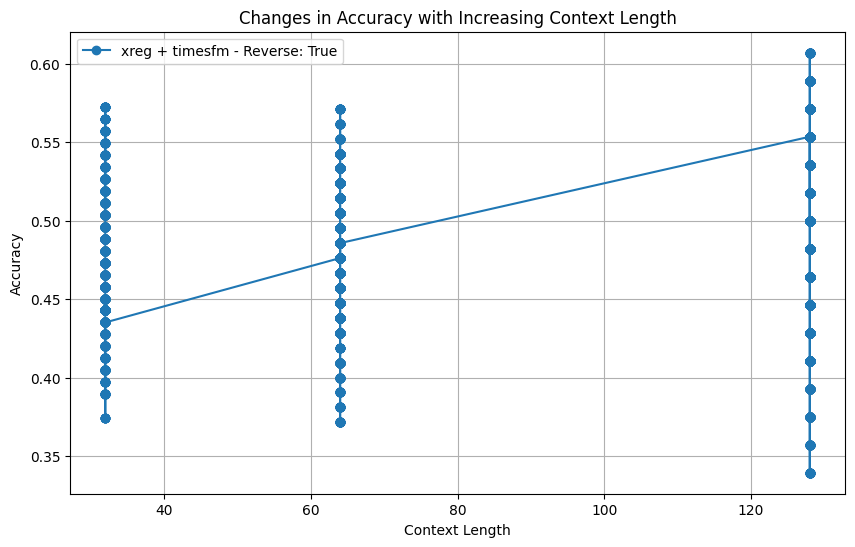

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# تبدیل all_results به یک DataFrame
flattened_results = [item for sublist in all_results for item in sublist]
results_df = pd.DataFrame(flattened_results)

# تابع برای رسم نمودار تغییرات
def plot_metric_changes(df, metric, y_label):
    plt.figure(figsize=(10, 6))
    for mode in df['xreg_mode'].unique():
        mode_df = df[df['xreg_mode'] == mode]
        plt.plot(mode_df['context_len'], mode_df[metric], marker='o', label=f'{mode} - Reverse: {mode_df["reverse"].iloc[0]}')
    plt.title(f'Changes in {y_label} with Increasing Context Length')
    plt.xlabel('Context Length')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()

# تابع برای تحلیل تغییرات بر اساس xreg_mode
def analyze_changes_by_mode(df):
    metrics = {
        'mse_model': 'MSE',
        'profit': 'Profit',
        'accuracy': 'Accuracy'
    }

    for metric, y_label in metrics.items():
        plot_metric_changes(df, metric, y_label)

# گروه‌بندی و تحلیل داده‌ها
grouped = results_df.groupby(['input_patch_len', 'xreg_mode', 'reverse'])

for (input_patch_len, xreg_mode, reverse), group in grouped:
    print(f"\nAnalyzing for Input Patch Length: {input_patch_len}, Mode: {xreg_mode}, Reverse: {reverse}...")
    analyze_changes_by_mode(group)



Analyzing for Input Patch Length: 32, Mode: timesfm + xreg, Reverse: False, Context Length: 64...


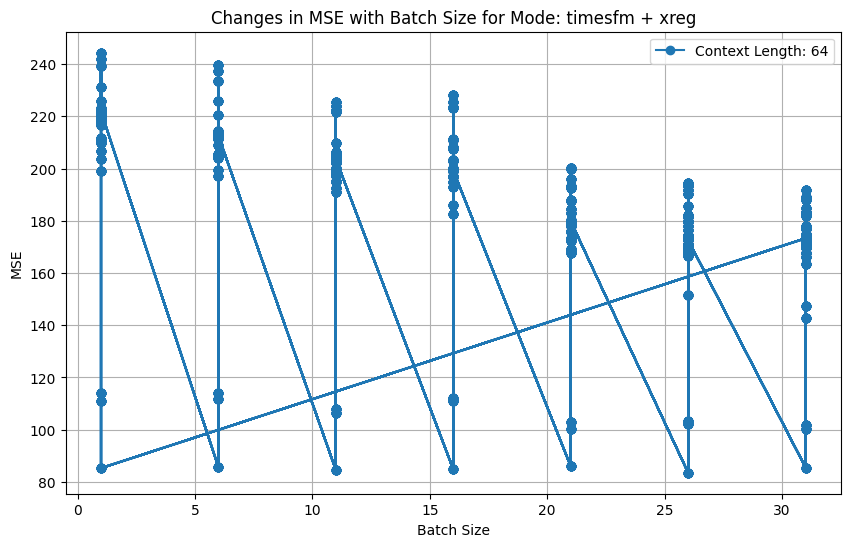

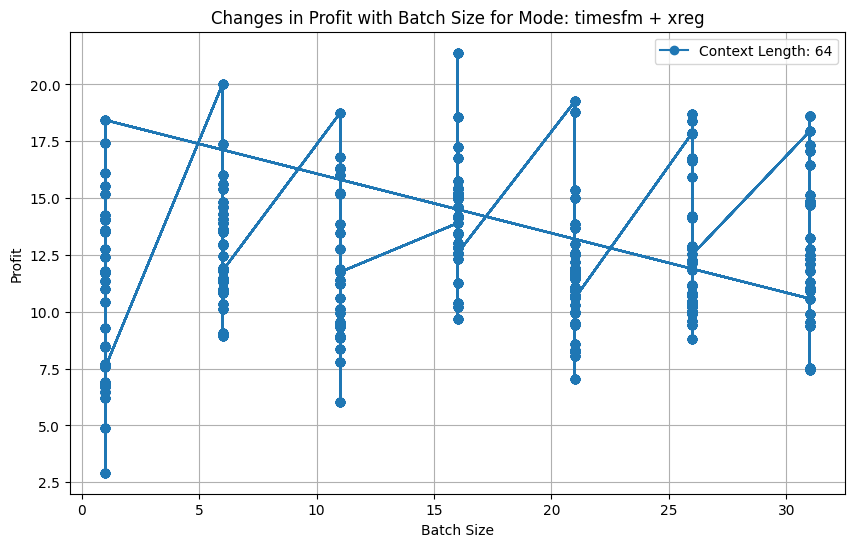

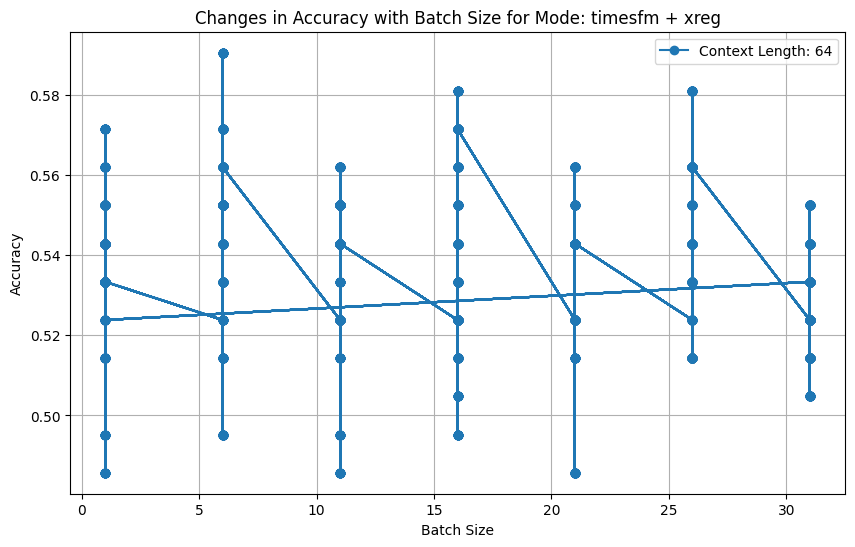


Analyzing for Input Patch Length: 32, Mode: timesfm + xreg, Reverse: False, Context Length: 128...


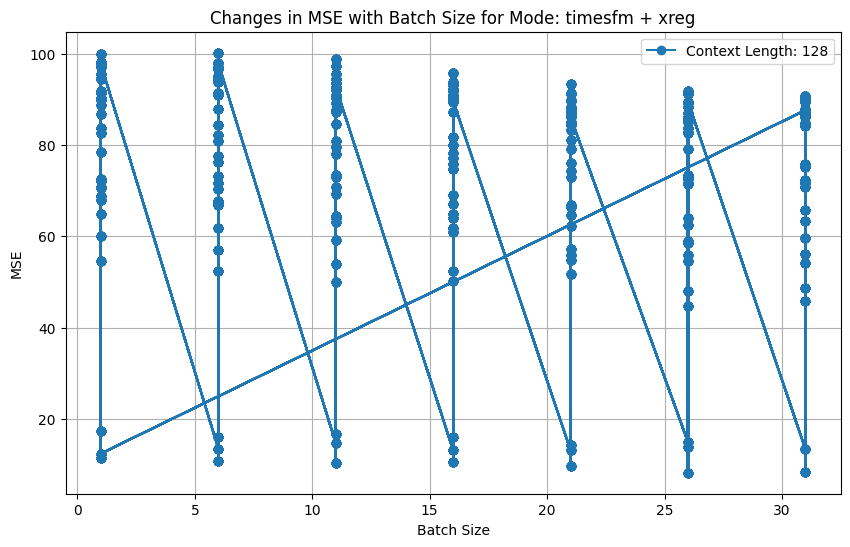

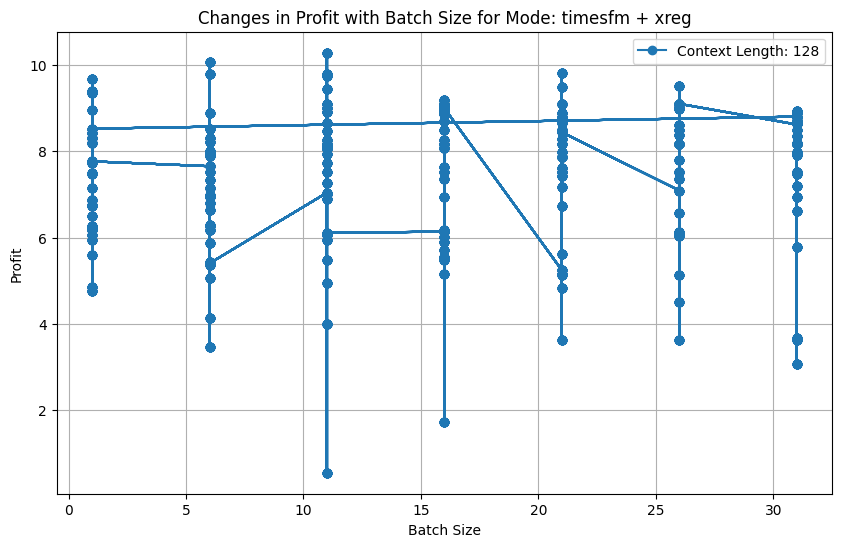

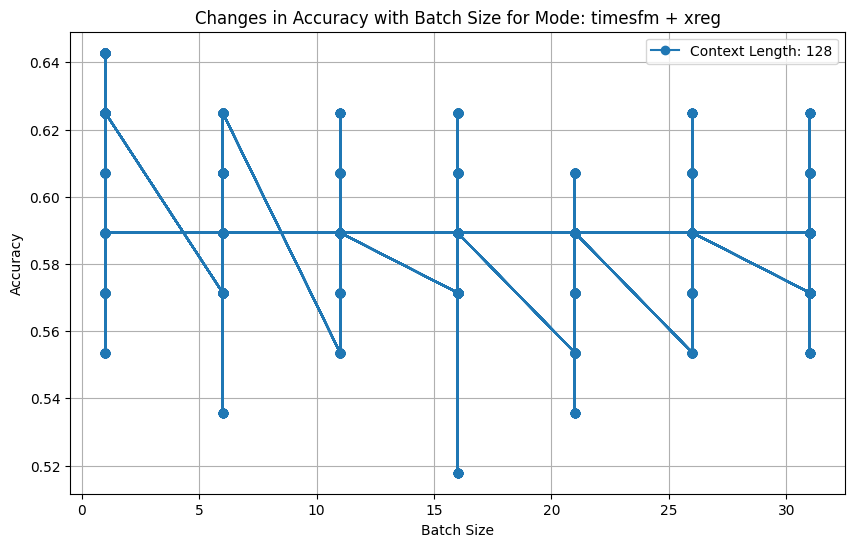


Analyzing for Input Patch Length: 32, Mode: xreg + timesfm, Reverse: True, Context Length: 32...


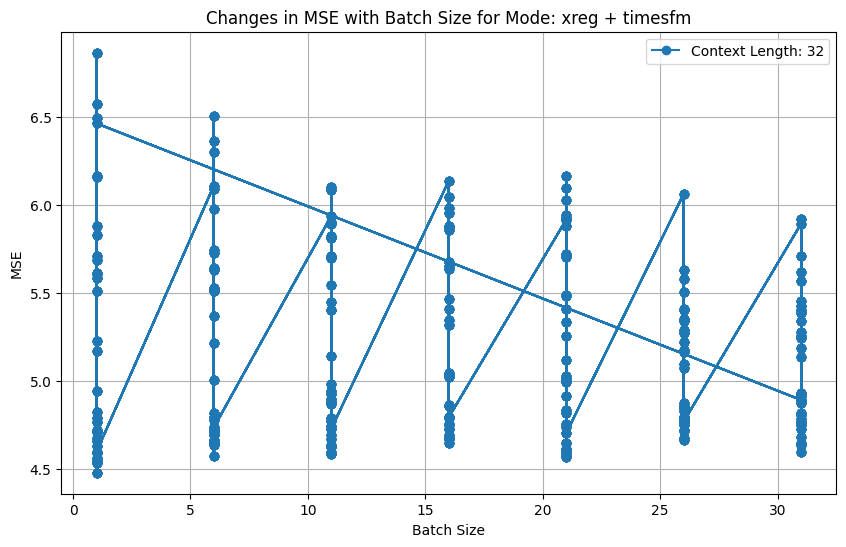

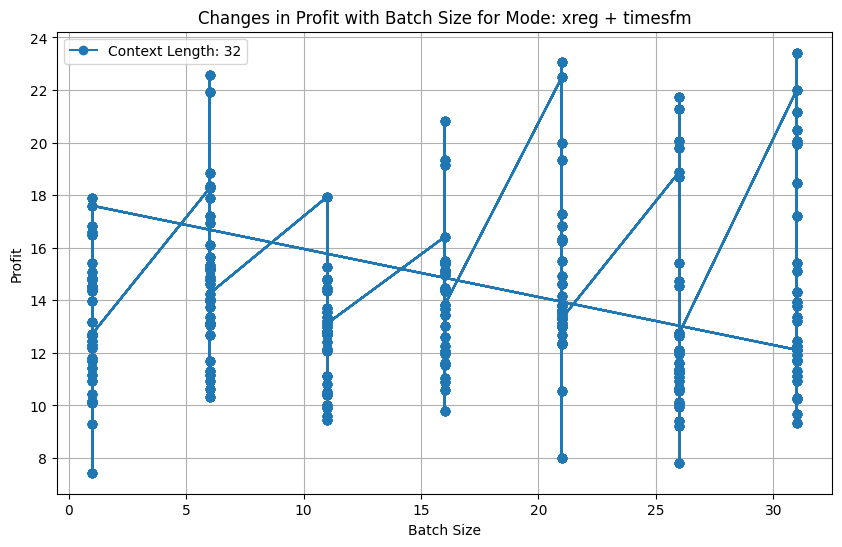

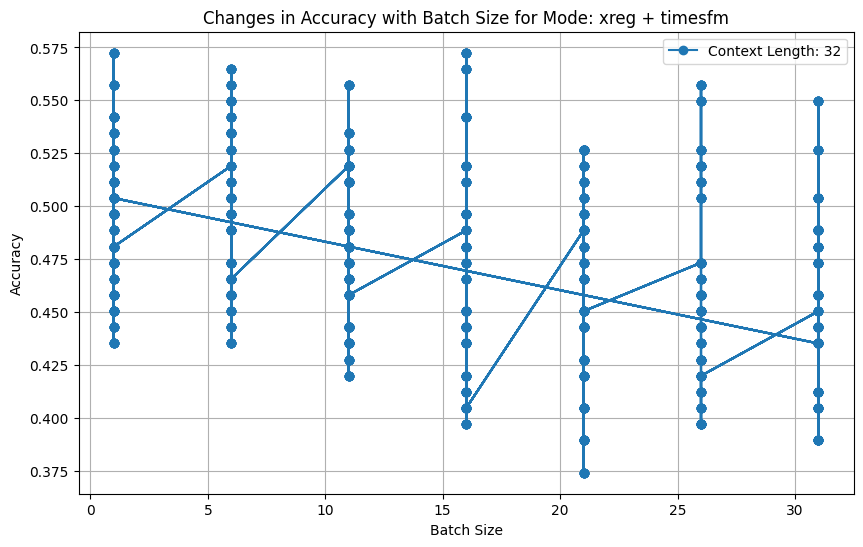


Analyzing for Input Patch Length: 32, Mode: xreg + timesfm, Reverse: True, Context Length: 64...


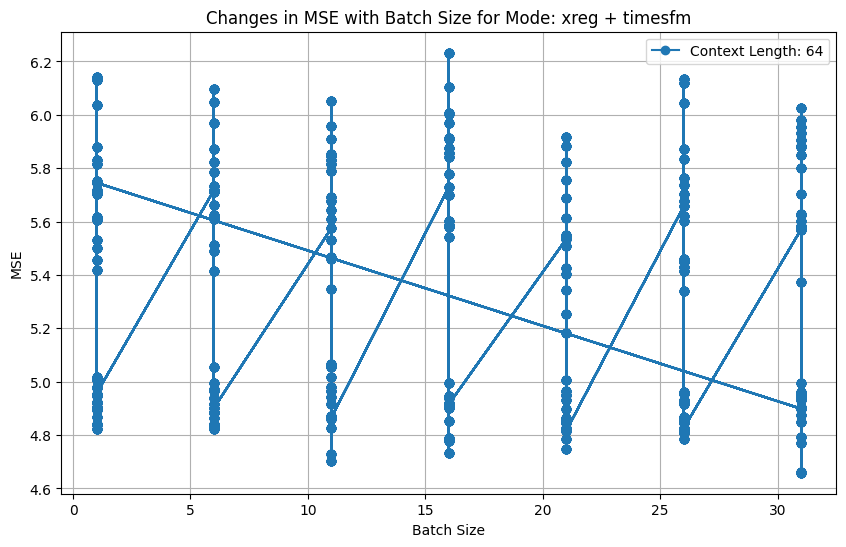

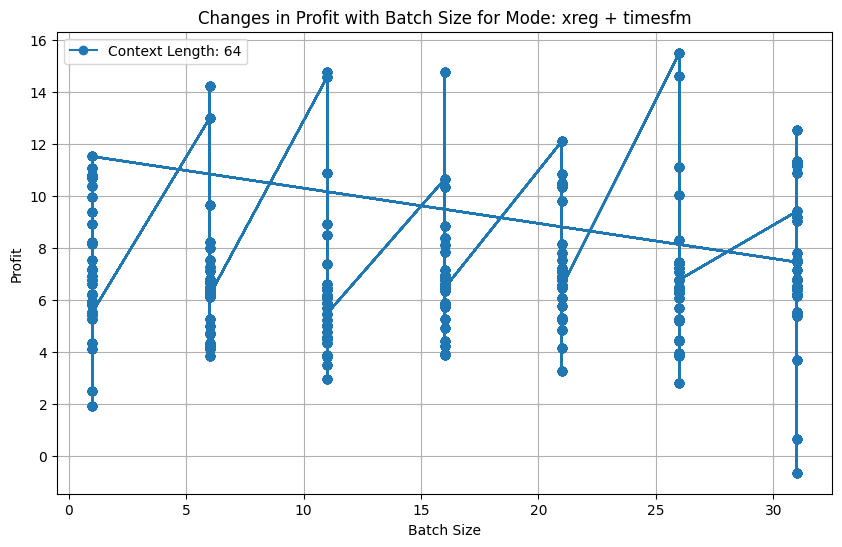

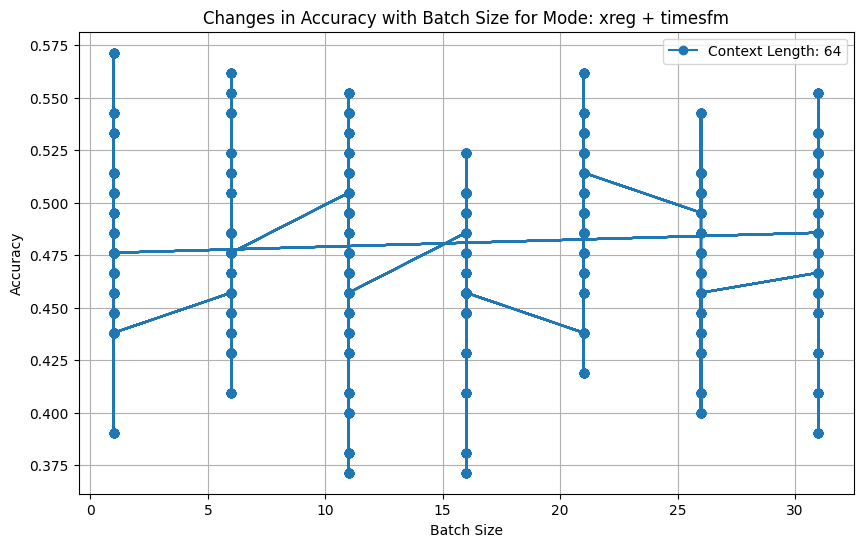


Analyzing for Input Patch Length: 32, Mode: xreg + timesfm, Reverse: True, Context Length: 128...


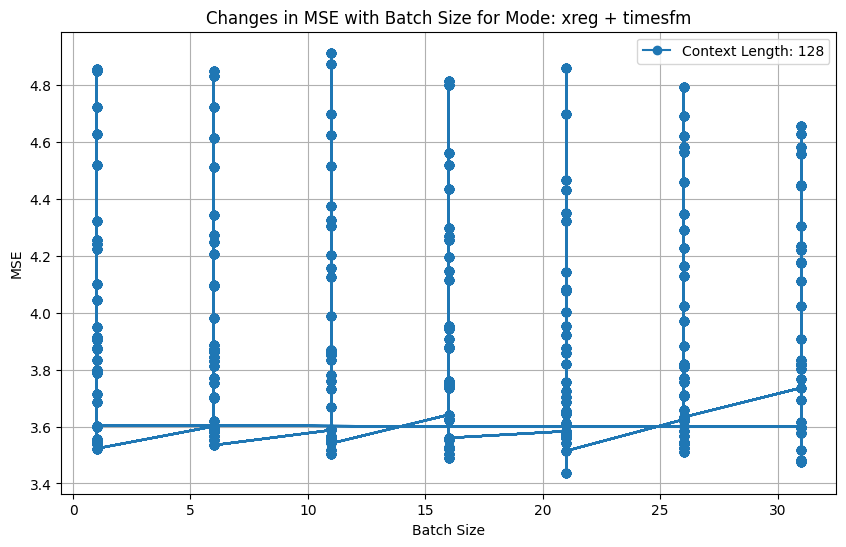

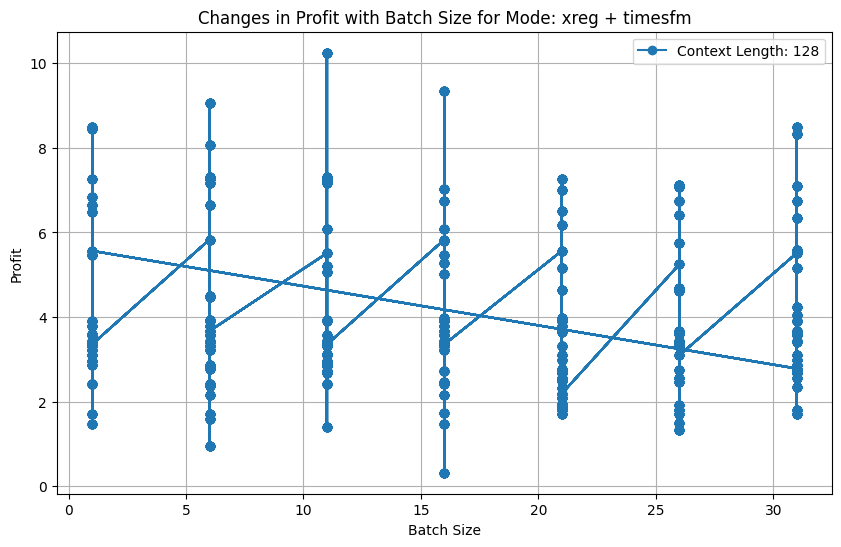

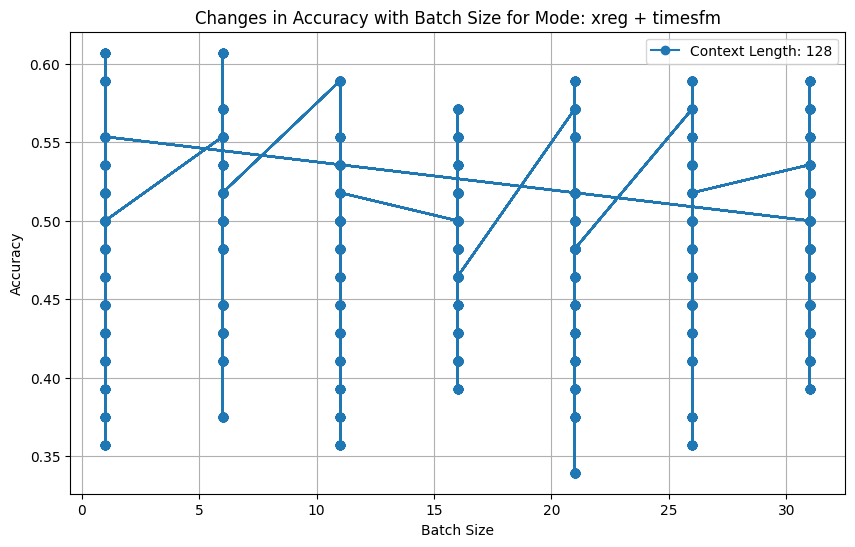

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# تبدیل all_results به یک DataFrame
flattened_results = [item for sublist in all_results for item in sublist]
results_df = pd.DataFrame(flattened_results)

# تابع برای رسم نمودار تغییرات بر اساس batch size
def plot_changes_by_batch_size(df, metric, y_label):
    plt.figure(figsize=(10, 6))
    for context_len in df['context_len'].unique():
        context_df = df[df['context_len'] == context_len]
        plt.plot(context_df['batch_size'], context_df[metric], marker='o', label=f'Context Length: {context_len}')
    plt.title(f'Changes in {y_label} with Batch Size for Mode: {df["xreg_mode"].iloc[0]}')
    plt.xlabel('Batch Size')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()

# تابع برای تحلیل تغییرات بر اساس xreg_mode و context_len
def analyze_changes_by_mode_and_context(df):
    metrics = {
        'mse_model': 'MSE',
        'profit': 'Profit',
        'accuracy': 'Accuracy'
    }

    for metric, y_label in metrics.items():
        plot_changes_by_batch_size(df, metric, y_label)

# گروه‌بندی و تحلیل داده‌ها
grouped = results_df.groupby(['input_patch_len', 'xreg_mode', 'reverse', 'context_len'])

for (input_patch_len, xreg_mode, reverse, context_len), group in grouped:
    print(f"\nAnalyzing for Input Patch Length: {input_patch_len}, Mode: {xreg_mode}, Reverse: {reverse}, Context Length: {context_len}...")
    analyze_changes_by_mode_and_context(group)


1. بهترین MSE:
Context Length: 128
Input Patch Length: 32
Batch Size: 21
ویژگی‌ها: (moving_avg_10, moving_avg_50, rsi, ema)
MSE: 3.437540
Accuracy: 0.517857
Profit: 2.696432
Reverse: True
Mode: xreg + timesfm




2. بهترین Profit:
Context Length: 64
Input Patch Length: 32
Batch Size: 16
ویژگی‌ها: (moving_avg_10,)
MSE: 207.306543
Accuracy: 0.52381
Profit: 21.398067
Reverse: False
Mode: timesfm + xreg



3. بهترین Accuracy:
Context Length: 128
Input Patch Length: 32
Batch Size: 1
ویژگی‌ها: (moving_avg_10, rsi)
MSE: 95.653064
Accuracy: 0.642857
Profit: 6.861246
Reverse: False
Mode: timesfm + xreg
